## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 9 : ODEs

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
import time
plt.style.use('mplstyle.txt')

### Tasks

1. Repeat the integration of the orbital encounter with Jupiter from Week 13 notebook. Use the same derivative function `f(t,y)` and the initial conditions (vx=10.5, vy=11.03, cosa=0.52), as well as the routine for calculating an adaptive timestep. Run the orbits with three integration schemes: our direct implementations of `leapfrog` and `Runge-Kutta`, and Scipy's `dopri5`. For each scheme, vary the parameters of the timestepping routine and find such that correctly capture the gravity assist effect but use the minimal required number of computations. One way of confirming correct orbit (that is, numerical convergence of the orbit integration) is to obtain the same X and Y positions of the satellite when it is far past Jupyter, at a distance of 10 AU away from the Sun.<br>

In [2]:
## Defining method functions ##

def f(t, y):
    # position of spacecraft
    xs = y[0]; ys = y[1]; zs = y[2]
    # position of Earth
    xe = y[6]; ye = y[7]; ze = y[8]
    # position of Jupiter
    xj = y[12]; yj = y[13]; zj = y[14]

    # relative distances of spacecraft from Sun, Earth, and Jupiter
    rs = np.sqrt(xs**2 + ys**2 + zs**2)
    rse = np.sqrt((xs-xe)**2 + (ys-ye)**2 + (zs-ze)**2)
    rsj = np.sqrt((xs-xj)**2 + (ys-yj)**2 + (zs-zj)**2)

    # acceleration of spacecraft from Sun, Earth, and Jupiter
    fs = -G*Msun/rs**3
    fse = -G*ME/rse**3
    fsj = -G*MJ/rsj**3

    # derivates of the phase-space coordinates of the spacecraft
    dy = np.zeros_like(y)
    dy[0] = y[3]; dy[1] = y[4]; dy[2] = y[5]
    dy[3] = fs*xs + fse*(xs-xe) + fsj*(xs-xj)
    dy[4] = fs*ys + fse*(ys-ye) + fsj*(ys-yj)
    dy[5] = fs*zs + fse*(zs-ze) + fsj*(zs-zj)
      
    # derivates of the phase-space coordinates of Earth
    dy[6] = y[9]; dy[7] = y[10]; dy[8] = y[11]
    re = np.sqrt(xe**2 + ye**2 + ze**2)
    rej = np.sqrt((xe-xj)**2 + (ye-yj)**2 + (ze-zj)**2)    
    fe = -G*Msun/re**3
    fej = -G*MJ/rej**3
    dy[9]  = fe*xe + fej*(xe-xj)
    dy[10] = fe*ye + fej*(ye-yj)
    dy[11] = fe*ze + fej*(ze-zj)

    # derivates of the phase-space coordinates of Jupiter
    dy[12] = y[15]; dy[13] = y[16]; dy[14] = y[17]
    rj = np.sqrt(xj**2 + yj**2 + zj**2)
    fj = -G*Msun/rj**3
    fje = -G*ME/rej**3
    dy[15] = fj*xj + fje*(xj-xe)
    dy[16] = fj*yj + fje*(yj-ye)
    dy[17] = fj*zj + fje*(zj-ze)
    return dy


def Energy(y):
    satellite_energy = True  # check energy conservation either for satellite or Earth
    xs = y[0]; ys = y[1]; zs = y[2]
    xe = y[6]; ye = y[7]; ze = y[8]
    xj = y[12]; yj = y[13]; zj = y[14]
    if satellite_energy:
        rs = np.sqrt(xs**2 + ys**2 + zs**2)
        rse = np.sqrt((xs-xe)**2 + (ys-ye)**2 + (zs-ze)**2)
        rsj = np.sqrt((xs-xj)**2 + (ys-yj)**2 + (zs-zj)**2)
        E = 0.5*(y[3]**2 + y[4]**2 + y[5]**2) - G*Msun/rs - G*ME/rse - G*MJ/rsj
    else:
        re = np.sqrt(xe**2 + ye**2 + ze**2)
        rej = np.sqrt((xe-xj)**2 + (ye-yj)**2 + (ze-zj)**2)
        E = 0.5*(y[9]**2 + y[10]**2 + y[11]**2) - G*Msun/re - G*MJ/rej
    return E

def timestep(y, dy, h):
    pos = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)    # position
    acc = np.sqrt(dy[3]**2 + dy[4]**2 + dy[5]**2) # acceleration
    
    hh = hfactor*np.sqrt(pos/acc)                 # estimated time step
    
    if hh < h/4 and h > hmin:   # decrease time step if it is more than twice estimated
        #print("hh=%.2e < h=%.2e r=%.6f"% (hh*yr, h*yr, pos))
        h /= 4
    
    if hh > 4*h:                # increase time step if it is less than half estimated
        #print("hh=%.2e > h=%.2e r=%.6f"% (hh*yr, h*yr, pos))
        h *= 4
    
    if h < hmin:    # do not allow time step to drop below this minimum
        h = hmin
    
    return h

def leapfrog(t, y, h):
    poslist = [ 0, 1, 2, 6, 7, 8, 12, 13, 14 ]
    vellist = [ 3, 4, 5, 9, 10, 11, 15, 16, 17 ]
    y_new = y
    # kick
    dy = f(t,y)
    for i in vellist:
        y_new[i] += dy[i]*h/2
    # drift
    for i in poslist:
        y_new[i] += y[i+3]*h
    # kick
    dy = f(t,y_new)
    for i in vellist:
        y_new[i] += dy[i]*h/2
    # estimate next timestep
    return y_new, timestep(y_new, dy, h)

def rungekutta(t, y, h):
    k1 = f(t, y)*h
    k2 = f(t+0.5*h, y+0.5*k1)*h
    k3 = f(t+0.5*h, y+0.5*k2)*h
    k4 = f(t+h, y+k3)*h
    y_new = y + (k1+2*k2+2*k3+k4)/6
    dy = k4/h
    return y_new, timestep(y_new, dy, h)

In [3]:
### Initial Conditions ###
                                        ##### in units of AU, km/s, and Msun #####
G = 8.89e2   # Gravitational constant        
Msun = 1     # mass of Sun
ME = 3.0e-6  # mass of Earth in solar masses
RE = 4.25e-5 # radius of Earth
MJ = 9.5e-4  # mass of Jupiter in solar masses
rJ = 5.2     # radius of Jupiter orbit
rJup_pl = 4.8e-4 # radius of Jupiter planet
yr = 4.75    # unit of time in years
tf = 10/yr   # finish time


# initial velocities of the spacecraft
vx = 10.5      # initial vertical velocity 
vy = 11.03  # 38   # carefully chosen horizontal velocity after launch

vE = np.sqrt(G*Msun/1.)  # orbital speed of Earth

# Jupiter orbit
cosa = 0.52    # assumed phase of Jupiter's orbit with respect to Earth
sina = np.sqrt(1-cosa**2)
vJ = np.sqrt(G*Msun/rJ)  # orbital speed of Jupiter

#      x        y        z  vx        vy       vz
y0 = [ 1+RE,    0,       0, vx,       vy+vE,   0, \
       1,       0,       0, 0,        vE,      0, \
       rJ*cosa, rJ*sina, 0, -vJ*sina, vJ*cosa, 0  ]

E0 = Energy(y0)

METHOD: Leapfrog
 running ...
dE/E = 2.65e-01 E0 = -6.26e+01 E = -4.60e+01
execution time = 35.334 seconds


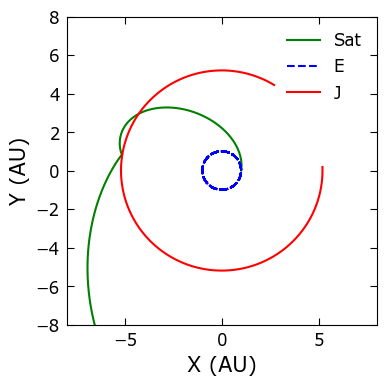

METHOD: Runge-Kutta
 running ...
dE/E = 2.66e-01 E0 = -6.26e+01 E = -4.59e+01
execution time = 5.983 seconds


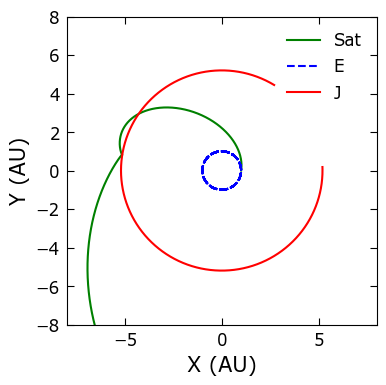

METHOD: scipy dopri5
 running ...


/Users/michaelstruk/miniconda3/lib/python3.12/site-packages/scipy/integrate/_ode.py:431: UserWarning: dopri5: larger nsteps is needed
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


dE/E = 2.66e-01 E0 = -6.26e+01 E = -4.59e+01
execution time = 2.084 seconds


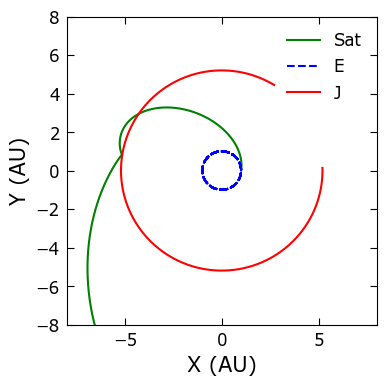

In [4]:
# defining the methods to loop over
methods = [leapfrog, rungekutta, ode]
names = ['Leapfrog', 'Runge-Kutta', 'scipy dopri5']

# initializing lists to collect time, energy, and positional values in 
rt, re, rxs, rys, rxe, rye, rxj, ryj = [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]]

# loop three times for each method
for i in [0,1,2]:
    print(f'METHOD: {names[i]}\n running ...')

    # initialize y values (initial conditions)
    y = np.copy(y0)
    
    # time step parameters
    t = 0
    if i==0: # leapfrog
        hfactor = 1e-5; hmin = 1e-9/yr; dt = 1e-8/yr
        
    if i==1: # runge-kutta
        hfactor = 1e-4; hmin = 1e-9/yr; dt = 1e-8/yr        

    if i==2: # scipy dopri5
        dt = 1e-4/yr
        # setup scipy integrator
        r = methods[i](f).set_integrator('dopri5', nsteps=25, rtol=1e-14, first_step=dt) # select scipy dopri5
        #dense_time_points = np.arange(t, tf, dt)
        
    # collect start time for computational efficiency analysis
    start_time = time.time()
    
    # integrate and save each iteration
    while t < tf:
        if i==0 or i==1:
            y, h = methods[i](t, y, dt)    # integrate orbit over dt
        else:
            r.set_initial_value(y,t) # initial conditions for integrator
            r.integrate(r.t+dt) # step-wise integration
            y = r.y # collect y values
            
        t += dt
        dt = h     # update with adaptive time step                 
        
        dE = abs((Energy(y)-E0)/E0)
        rt[i].append(t*yr); re[i].append(dE)
        rxs[i].append(y[0]); rys[i].append(y[1])
        rxe[i].append(y[6]); rye[i].append(y[7])
        rxj[i].append(y[12]); ryj[i].append(y[13])
        
    
    print('dE/E = %.2e E0 = %.2e E = %.2e'%( dE, E0, Energy(y) ))
    print('execution time = %.3f seconds'%( time.time() - start_time ))

    # visualize orbits
    plt.figure(figsize=(4,4))
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.xlabel('X (AU)')
    plt.ylabel('Y (AU)')
    
    plt.plot(rxs[i], rys[i], 'g-', label='Sat')
    plt.plot(rxe[i], rye[i], 'b--', label='E')
    plt.plot(rxj[i], ryj[i], 'r-', label='J')
    plt.legend()
    plt.show()

In [5]:
# distance of satellite from sun
dsat_LF = (np.array(rxs[0])**2 + np.array(rys[0])**2)**0.5
dsat_RK = (np.array(rxs[1])**2 + np.array(rys[1])**2)**0.5
dsat_sp = (np.array(rxs[2])**2 + np.array(rys[2])**2)**0.5

# defining indices where satellite is >10 AU away
far_awayLF = np.where(dsat_LF>10)
far_awayRK = np.where(dsat_RK>10)
far_awaysp = np.where(dsat_sp>10)

# distance between satellite and jupiter
dsat_LFJ = ((np.array(rxs[0])-np.array(rxj[0]))**2 + (np.array(rys[0])-np.array(ryj[0]))**2)**0.5
dsat_RKJ = ((np.array(rxs[1])-np.array(rxj[1]))**2 + (np.array(rys[1])-np.array(ryj[1]))**2)**0.5
dsat_spJ = ((np.array(rxs[2])-np.array(rxj[2]))**2 + (np.array(rys[2])-np.array(ryj[2]))**2)**0.5

# finding point of closest approach
closeLFJ = np.argmin(dsat_LFJ)
closeRKJ = np.argmin(dsat_RKJ)
closespJ = np.argmin(dsat_spJ)
close_pts = [closeLFJ, closeRKJ, closespJ]

In [6]:
# checking far away points for convergence
print('Check convergence with last 5 farthest coordinates ([x  y])' )
print('-----------------------------------------------------------')
print('leapfrog')
print(np.concatenate((np.array(rxs[0])[far_awayLF][-6:-1].reshape(5,1), np.array(rys[0])[far_awayLF][-6:-1].reshape(5,1)),axis=1))
print()
print('runge-kutta')
print(np.concatenate((np.array(rxs[1])[far_awayRK][-6:-1].reshape(5,1), np.array(rys[1])[far_awayRK][-6:-1].reshape(5,1)),axis=1))
print()
print('dopri 5')
print(np.concatenate((np.array(rxs[2])[far_awaysp][-6:-1].reshape(5,1), np.array(rys[2])[far_awaysp][-6:-1].reshape(5,1)), axis=1))

Check convergence with last 5 farthest coordinates ([x  y])
-----------------------------------------------------------
leapfrog
[[ -4.80217327 -11.81998876]
 [ -4.80213852 -11.82003695]
 [ -4.80210377 -11.82008514]
 [ -4.80206901 -11.82013333]
 [ -4.80203426 -11.82018152]]

runge-kutta
[[ -4.80697701 -11.82363178]
 [ -4.80642171 -11.82440413]
 [ -4.80586636 -11.82517638]
 [ -4.80531098 -11.82594853]
 [ -4.80475556 -11.82672059]]

dopri 5
[[ -4.82170063 -11.80312865]
 [ -4.82114637 -11.80390356]
 [ -4.82059207 -11.80467836]
 [ -4.82003773 -11.80545308]
 [ -4.81948335 -11.80622769]]


* As defined above, the last points in the motion of the satellite for each three methods is extremely similar, implying that their solutions have all converged given our set of initial conditions. They only vary on the order of $10^{-3}$. These same timestep parameters will be used throughout the rest of the notebook.

2. Investigate the orbit near the close encounter with Jupyter and make plots showing the close-up of the orbit and energy change. Check that the spacecraft does not plunge inside the radius of Jupyter, which equals 4.8e-4 AU, at the point of closest approach. If it does go inside, change the initial launch velocity slightly to avoid it but still have the gravity assist effect.<br>

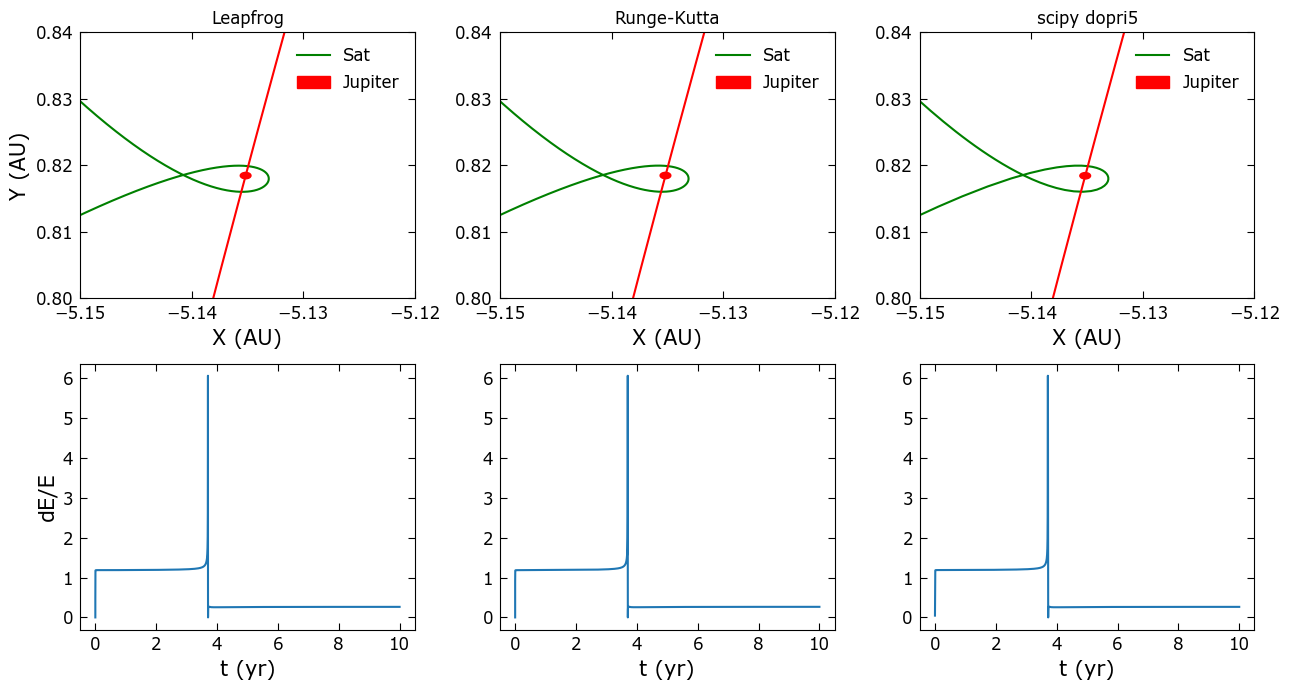

In [7]:
from matplotlib.patches import Circle

fig, axes = plt.subplots(2, 3, figsize=(13, 7))
for i in [0, 1, 2]:
    # upper row: zoomed in paths
    ax = axes[0, i]
    ax.set_title(f'{names[i]}')
    ax.plot(rxs[i], rys[i], 'g-', label='Sat')
    ax.plot(rxe[i], rye[i], 'b--')
    ax.plot(rxj[i], ryj[i], 'r-')
    if i!=2:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    else:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    
    
    ax.set_ylim(0.75, 0.85)
    ax.set_xlabel('X (AU)')
    ax.legend()
    if i == 0:
        ax.set_ylabel('Y (AU)')
        # ax.set_ylim(0.7, 0.74)
        # ax.set_xlim(-5.165, -5.135)
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
    else:
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
        
    # lower row: energy change
    ax = axes[1,i]
    ax.plot(rt[i], re[i])
    ax.set_xlabel('t (yr)')
    #ax.set_xlim(3,4.2)
    if i==0:
        ax.set_ylabel('dE/E')
        
plt.tight_layout()
plt.show();


* With the red point on Jupiter's orbit being Jupiter's physical size/position at the point of closest approach, we can see that the satellite never plunges into the planet.

3. Now add Mars as another mass component. You will need to modify the derivative function and the initial setup. Mars's mass is 3.2e-7 solar masses, orbital radius is 1.5 AU.<br>

In [8]:
## re-defining functions to include Mars ##

def f(t, y):
    # position of spacecraft
    xs = y[0]; ys = y[1]; zs = y[2]
    # position of Earth
    xe = y[6]; ye = y[7]; ze = y[8]
    # position of Jupiter
    xj = y[12]; yj = y[13]; zj = y[14]
    # position of Mars
    xm = y[18]; ym = y[19]; zm = y[20]

    # relative distances of spacecraft from Sun, Earth, Mars, & Jupiter
    rs = np.sqrt(xs**2 + ys**2 + zs**2)  # spacecraft to Sun
    rse = np.sqrt((xs - xe)**2 + (ys - ye)**2 + (zs - ze)**2)  # spacecraft to Earth
    rsj = np.sqrt((xs - xj)**2 + (ys - yj)**2 + (zs - zj)**2)  # spacecraft to Jupiter
    rsm = np.sqrt((xs - xm)**2 + (ys - ym)**2 + (zs - zm)**2)  # spacecraft to Mars
    re = np.sqrt(xe**2 + ye**2 + ze**2)  # Earth to Sun
    rej = np.sqrt((xe - xj)**2 + (ye - yj)**2 + (ze - zj)**2)  # Earth to Jupiter
    rm = np.sqrt(xm**2 + ym**2 + zm**2)  # Mars to Sun
    rmj = np.sqrt((xm - xj)**2 + (ym - yj)**2 + (zm - zj)**2) # Mars to Jupiter
    rem =  np.sqrt((xm - xe)**2 + (ym - ye)**2 + (zm - ze)**2)# Earth to Mars
    rj = np.sqrt(xj**2 + yj**2 + zj**2) # Jupiter to Sun

    # acceleration of spacecraft from Sun, Earth, Mars, and Jupiter
    fs = -G * Msun / rs**3
    fse = -G * ME / rse**3
    fsj = -G * MJ / rsj**3
    fsm = -G * MM / rsm**3
    fe = -G * Msun / re**3
    fje = -G * MJ / rej**3
    fem = -G * MM / rem**3
    fm = -G * Msun / rm**3
    fj = -G * Msun / rj**3

    # derivatives
    dy = np.zeros_like(y)

    # phase-space coordinates of spacecraft
    dy[0] = y[3]; dy[1] = y[4]; dy[2] = y[5]
    dy[3] = fs * xs + fse * (xs - xe) + fsj * (xs - xj) + fsm * (xs - xm)  
    dy[4] = fs * ys + fse * (ys - ye) + fsj * (ys - yj) + fsm * (ys - ym)
    dy[5] = fs * zs + fse * (zs - ze) + fsj * (zs - zj) + fsm * (zs - zm)

    # phase-space coordinates of Earth
    dy[6] = y[9]; dy[7] = y[10]; dy[8] = y[11]  
    dy[9] = fe * xe + fje * (xe - xj)  
    dy[10] = fe * ye + fje * (ye - yj)
    dy[11] = fe * ze + fje * (ze - zj)

    # phase-space coordinates of Jupiter
    dy[12] = y[15]; dy[13] = y[16]; dy[14] = y[17]  
    dy[15] = fj * xj + fje * (xj - xe)  
    dy[16] = fj * yj + fje * (yj - ye)
    dy[17] = fj * zj + fje * (zj - ze)

    # phase-space coordinates of Mars
    dy[18] = y[21]; dy[19] = y[22]; dy[20] = y[23]  
    dy[21] = fm * xm  
    dy[22] = fm * ym
    dy[23] = fm * zm

    return dy


def Energy(y):
    satellite_energy = True  # check energy conservation either for satellite (True) or Earth (False)
    xs = y[0]; ys = y[1]; zs = y[2]
    xe = y[6]; ye = y[7]; ze = y[8]
    xj = y[12]; yj = y[13]; zj = y[14]
    xm = y[18]; ym = y[19]; zm = y[20]
    
    if satellite_energy:
        rs = np.sqrt(xs**2 + ys**2 + zs**2)
        rse = np.sqrt((xs-xe)**2 + (ys-ye)**2 + (zs-ze)**2)
        rsj = np.sqrt((xs-xj)**2 + (ys-yj)**2 + (zs-zj)**2)
        rsm = np.sqrt((xs-xm)**2 + (ys-ym)**2 + (zs-zm)**2)
        E = 0.5*(y[3]**2 + y[4]**2 + y[5]**2) - G*Msun/rs - G*ME/rse - G*MJ/rsj - G*MM/rsm
    else:
        re = np.sqrt(xe**2 + ye**2 + ze**2)
        rej = np.sqrt((xe-xj)**2 + (ye-yj)**2 + (ze-zj)**2)
        E = 0.5*(y[9]**2 + y[10]**2 + y[11]**2) - G*Msun/re - G*MJ/rej
    return E


def timestep(y, dy, h):
    pos = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)    # position
    acc = np.sqrt(dy[3]**2 + dy[4]**2 + dy[5]**2) # acceleration
    
    hh = hfactor*np.sqrt(pos/acc)                 # estimated time step
    
    if hh < h/4 and h > hmin:   # decrease time step if it is more than twice estimated
        #print("hh=%.2e < h=%.2e r=%.6f"% (hh*yr, h*yr, pos))
        h /= 4
    
    if hh > 4*h:                # increase time step if it is less than half estimated
        #print("hh=%.2e > h=%.2e r=%.6f"% (hh*yr, h*yr, pos))
        h *= 4
    
    if h < hmin:    # do not allow time step to drop below this minimum
        h = hmin
    
    return h

def leapfrog(t, y, h):
    poslist = [ 0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20 ] # with added indices for Mars
    vellist = [ 3, 4, 5, 9, 10, 11, 15, 16, 17, 21, 22, 23 ]
    y_new = y
    # kick
    dy = f(t,y)
    for i in vellist:
        y_new[i] += dy[i]*h/2
    # drift
    for i in poslist:
        y_new[i] += y[i+3]*h
    # kick
    dy = f(t,y_new)
    for i in vellist:
        y_new[i] += dy[i]*h/2
    # estimate next timestep
    return y_new, timestep(y_new, dy, h)

def rungekutta(t, y, h):
    k1 = f(t, y)*h
    k2 = f(t+0.5*h, y+0.5*k1)*h
    k3 = f(t+0.5*h, y+0.5*k2)*h
    k4 = f(t+h, y+k3)*h
    y_new = y + (k1+2*k2+2*k3+k4)/6
    dy = k4/h
    return y_new, timestep(y_new, dy, h)

In [9]:
## Initial Conditions (INCLUDING MARS) ###
                                        #### in units of AU, km/s, and Msun #####
G = 8.89e2   # Gravitational constant        
Msun = 1     # mass of Sun
ME = 3.0e-6  # mass of Earth in solar masses
RE = 4.25e-5 # radius of Earth
MJ = 9.5e-4  # mass of Jupiter in solar masses
rJ = 5.2     # radius of Jupiter orbit
rJup_pl = 4.8e-4 # radius of Jupiter planet
MM = 3.2e-7 # mass of Mars in solar masses
rM = 1.5 # radius of Mars orbit
yr = 4.75    # unit of time in years
tf = 10/yr   # finish time

# initial velocities of the spacecraft
vx = 10.5      # initial vertical velocity 
vy = 11.031   # 38   # carefully chosen horizontal velocity after launch

vE = np.sqrt(G*Msun/1.)  # orbital speed of Earth
vM = np.sqrt(G * Msun / rM)  # orbital speed of Mars

# Jupiter orbit
cosa = 0.52    # assumed phase of Jupiter's orbit with respect to Earth
sina = np.sqrt(1-cosa**2)
vJ = np.sqrt(G*Msun/rJ)  # orbital speed of Jupiter

#      x        y        z  vx        vy       vz
y0 = [ 1+RE,    0,       0, vx,       vy+vE,   0, \
       1,       0,       0, 0,        vE,      0, \
       rJ*cosa, rJ*sina, 0, -vJ*sina, vJ*cosa, 0, \
       -rM,      0,       0, 0,        -vM,      0  ] # additional Mars initial conditions

E0 = Energy(y0)

4. Investigate how the spacecraft orbit differs from the first case. For the analysis of the orbit: (i) plot the orbit; (ii) compare the maximum energy change for the different integration methods; (iii) check the orbit excursion into the $Z$ direction outside the ecliptic plane.<br>



METHOD: Leapfrog
 running ...
dE/E = 1.36e+00 E0 = -6.25e+01 E = 2.24e+01
execution time = 48.943 seconds


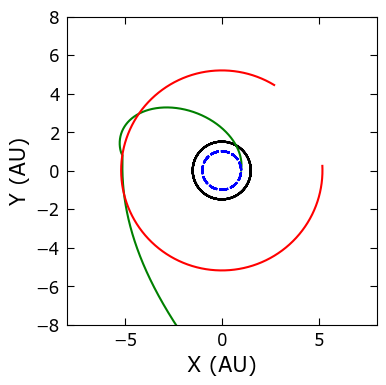

METHOD: Runge-Kutta
 running ...
dE/E = 1.36e+00 E0 = -6.25e+01 E = 2.24e+01
execution time = 7.232 seconds


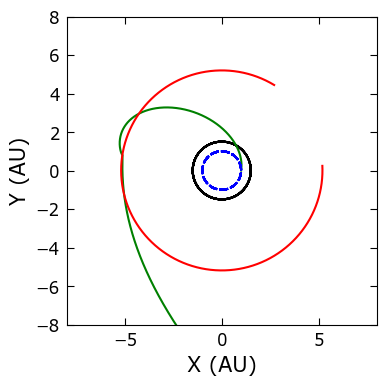

METHOD: scipy dopri5
 running ...
dE/E = 1.36e+00 E0 = -6.25e+01 E = 2.24e+01
execution time = 2.915 seconds


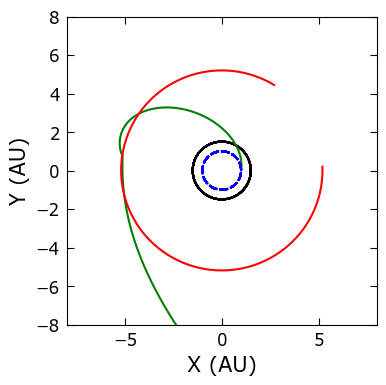

In [10]:
methods = [leapfrog, rungekutta, ode]
names = ['Leapfrog', 'Runge-Kutta', 'scipy dopri5']

rt, re, rxs, rys, rzs, rxe, rye, rze, rxj, ryj, rzj, rxm, rym, rzm = [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]]


for i in [0,1,2]:
    print(f'METHOD: {names[i]}\n running ...')

    # initialize y values (initial conditions)
    y = np.copy(y0)
    
    # time step parameters
    t = 0
    if i==0: # leapfrog
        hfactor = 1e-5; hmin = 1e-9/yr; dt = 1e-8/yr
        
    if i==1: # runge-kutta
        hfactor = 1e-4; hmin = 1e-9/yr; dt = 1e-8/yr        

    if i==2: # scipy dopri5
        dt = 1e-4/yr
        # setup scipy integrator
        r = methods[i](f).set_integrator('dopri5', nsteps=25, rtol=1e-14, first_step=dt) # select scipy dopri5
        #dense_time_points = np.arange(t, tf, dt)
        
    # collect start time for computational efficiency analysis
    start_time = time.time()
    
    # integrate and save each iteration
    while t < tf:
        if i==0 or i==1:
            y, h = methods[i](t, y, dt)    # integrate orbit over dt
        else:
            r.set_initial_value(y,t) # initial conditions for integrator
            r.integrate(r.t+dt) # step-wise integration
            y = r.y # collect y values
        t += dt
        dt = h                            
        
        dE = abs((Energy(y)-E0)/E0)
        rt[i].append(t*yr); re[i].append(dE)
        rxs[i].append(y[0]); rys[i].append(y[1]); rzs[i].append(y[2])
        rxe[i].append(y[6]); rye[i].append(y[7]); rze[i].append(y[8])
        rxj[i].append(y[12]); ryj[i].append(y[13]); rzj[i].append(y[14])
        rxm[i].append(y[18]); rym[i].append(y[19]); rzm[i].append(y[20])
        
        
    
    print('dE/E = %.2e E0 = %.2e E = %.2e'%( dE, E0, Energy(y) ))
    print('execution time = %.3f seconds'%( time.time() - start_time ))

    # visualize orbits
    plt.figure(figsize=(4,4))
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.xlabel('X (AU)')
    plt.ylabel('Y (AU)')

    plt.plot(rxm[i], rym[i], 'k-')
    plt.plot(rxs[i], rys[i], 'g-')
    plt.plot(rxe[i], rye[i], 'b--')
    plt.plot(rxj[i], ryj[i], 'r-')
    
    plt.show()

In [11]:
# distance of satellite from sun
dsat_LF = (np.array(rxs[0])**2 + np.array(rys[0])**2)**0.5
dsat_RK = (np.array(rxs[1])**2 + np.array(rys[1])**2)**0.5
dsat_sp = (np.array(rxs[2])**2 + np.array(rys[2])**2)**0.5

# defining indices where satellite is >10 AU away
far_awayLF = np.where(dsat_LF>10)
far_awayRK = np.where(dsat_RK>10)
far_awaysp = np.where(dsat_sp>10)

# distance between satellite and jupiter
dsat_LFJ = ((np.array(rxs[0])-np.array(rxj[0]))**2 + (np.array(rys[0])-np.array(ryj[0]))**2)**0.5
dsat_RKJ = ((np.array(rxs[1])-np.array(rxj[1]))**2 + (np.array(rys[1])-np.array(ryj[1]))**2)**0.5
dsat_spJ = ((np.array(rxs[2])-np.array(rxj[2]))**2 + (np.array(rys[2])-np.array(ryj[2]))**2)**0.5

# finding point of closest approach
closeLFJ = np.argmin(dsat_LFJ)
closeRKJ = np.argmin(dsat_RKJ)
closespJ = np.argmin(dsat_spJ)
close_pts = [closeLFJ, closeRKJ, closespJ]

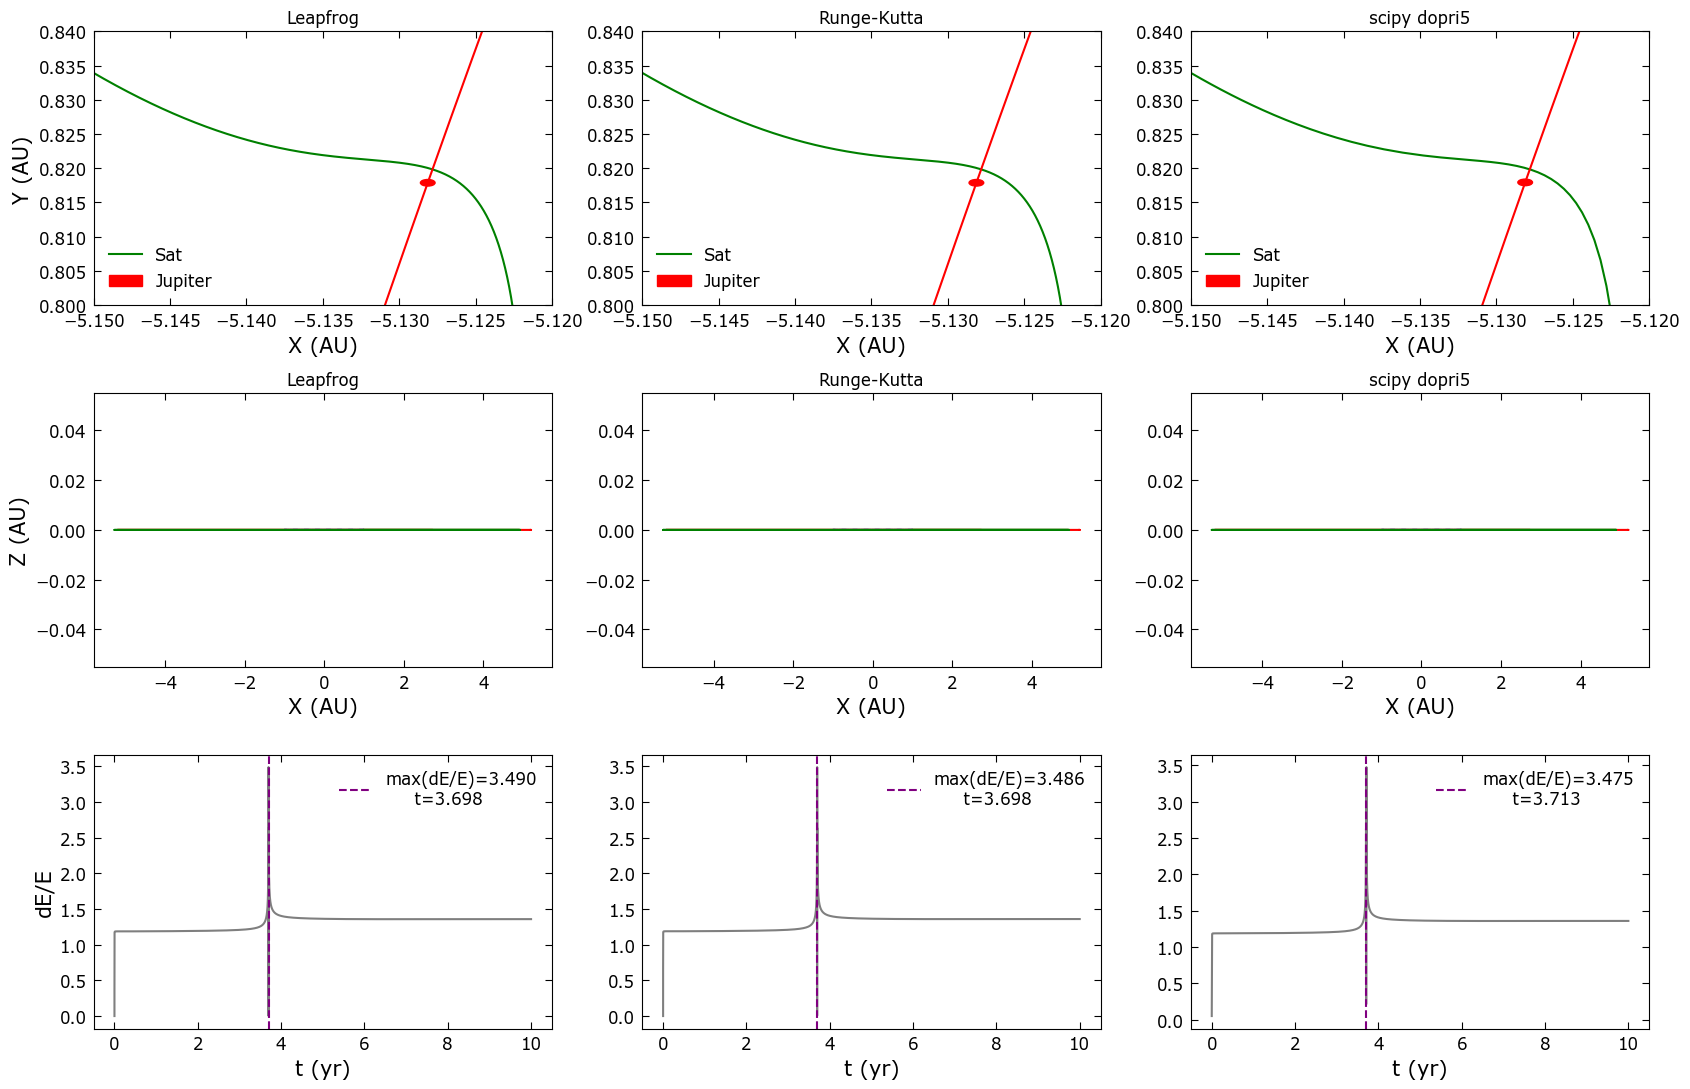

In [12]:
from matplotlib.patches import Circle

fig, axes = plt.subplots(3, 3, figsize=(17, 11))
for i in [0, 1, 2]:
    # upper row: zoomed in paths
    ax = axes[0, i]
    ax.set_title(f'{names[i]}')
    ax.plot(rxs[i], rys[i], 'g-', label='Sat')
    ax.plot(rxe[i], rye[i], 'b--')
    ax.plot(rxj[i], ryj[i], 'r-')
    if i!=2:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    else:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    
    
    #ax.set_ylim(0.75, 0.85)
    ax.set_xlabel('X (AU)')
    ax.legend()
    if i == 0:
        ax.set_ylabel('Y (AU)')
        #ax.set_ylim(0.7, 0.74)
        #ax.set_xlim(-5.165, -5.135)
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
    else:
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
    
    # middle row: Z direction excursion
    ax = axes[1, i]
    ax.set_title(f'{names[i]}')
    ax.plot(rxe[i], rze[i], 'b--')
    ax.plot(rxj[i], rzj[i], 'r-')
    ax.plot(rxs[i], rzs[i], 'g-')
    ax.set_xlabel('X (AU)')
    if i == 0:
        ax.set_ylabel('Z (AU)')

    # lower row: energy change
    ax = axes[2,i]
    ax.plot(rt[i], re[i], 'k', alpha=0.5)
    ax.axvline(rt[i][np.argmax(re[i])], color='purple',linestyle='--', label=f'max(dE/E)={np.max(re[i]):.3f}\n     t={rt[i][np.argmax(re[i])]:.3f}')
    ax.set_xlabel('t (yr)')
    #ax.set_xlim(3,4.2)
    if i==0:
        ax.set_ylabel('dE/E')
    ax.legend()
        
plt.tight_layout()
plt.show();


* Including Mars in the calculation, I was never able to attain gravity assist with Jupiter, no matter my initial conditions. It still doesn't plunge into the planet at their point of closest approach. Interestingly, the same initial conditions produce gravity assist when Mars is 1000x more massive in the next section.
* There is no excursion off of the Z plane, which is expected since it doesn't exist naturally and we didn't force it to occur. Any motion in the middle row of plots ($Z$ vs. $X$) would be the result of error in the integration.
* The leapfrog method had the largest deviation from true energy conservation, though they are all within $10^{-2}$ of each other. This is expected alongside its inferior computational efficiency to the other methods.

5. Now imagine Mars were 1000 times more massive. Repeat the orbit calculation. Describe how the result change.<br>

In [13]:
# adjust the mass of Mars
MM = 3.2e-4 # solar masses
vy = 11.0295   # carefully chosen horizontal velocity after launch

#      x        y        z  vx        vy       vz
y0 = [ 1+RE,    0,       0, vx,       vy+vE,   0, \
       1,       0,       0, 0,        vE,      0, \
       rJ*cosa, rJ*sina, 0, -vJ*sina, vJ*cosa, 0, \
       -rM,     0,       0, 0,        -vM,      0  ]

E0 = Energy(y0)

METHOD: Leapfrog
 running ...
dE/E = 3.60e-01 E0 = -6.27e+01 E = -4.01e+01
execution time = 48.085 seconds


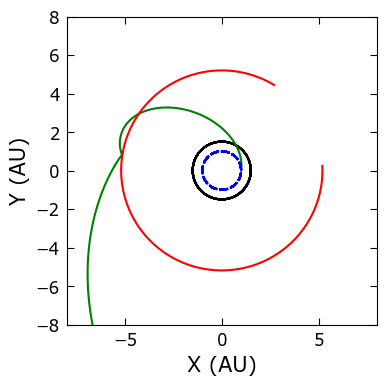

METHOD: Runge-Kutta
 running ...
dE/E = 3.61e-01 E0 = -6.27e+01 E = -4.00e+01
execution time = 7.491 seconds


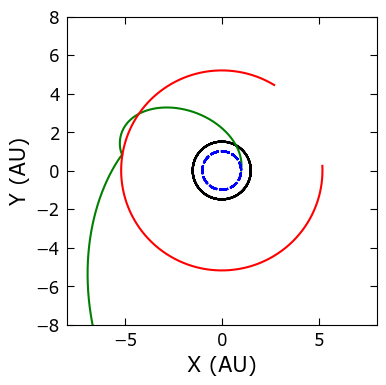

METHOD: scipy dopri5
 running ...
dE/E = 3.61e-01 E0 = -6.27e+01 E = -4.00e+01
execution time = 2.859 seconds


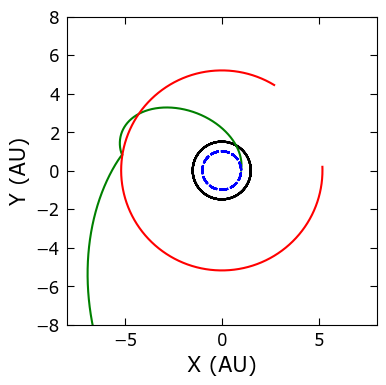

In [14]:
methods = [leapfrog, rungekutta, ode]
names = ['Leapfrog', 'Runge-Kutta', 'scipy dopri5']

rt, re, rxs, rys, rxe, rye, rxj, ryj, rxm, rym = [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]]


for i in [0,1,2]:
    print(f'METHOD: {names[i]}\n running ...')

    # initialize y values (initial conditions)
    y = np.copy(y0)
    
    # time step parameters
    t = 0
    if i==0: # leapfrog
        hfactor = 1e-5; hmin = 1e-9/yr; dt = 1e-8/yr
        
    if i==1: # runge-kutta
        hfactor = 1e-4; hmin = 1e-9/yr; dt = 1e-8/yr        

    if i==2: # scipy dopri5
        dt = 1e-4/yr
        # setup scipy integrator
        r = methods[i](f).set_integrator('dopri5', nsteps=25, rtol=1e-14, first_step=dt) # select scipy dopri5
        #dense_time_points = np.arange(t, tf, dt)
        
    # collect start time for computational efficiency analysis
    start_time = time.time()
    
    # integrate and save each iteration
    while t < tf:
        if i==0 or i==1:
            y, h = methods[i](t, y, dt)    # integrate orbit over dt
        else:
            r.set_initial_value(y,t) # initial conditions for integrator
            r.integrate(r.t+dt) # step-wise integration
            y = r.y # collect y values
        t += dt
        dt = h                            
        
        dE = abs((Energy(y)-E0)/E0)
        rt[i].append(t*yr); re[i].append(dE)
        rxs[i].append(y[0]); rys[i].append(y[1])
        rxe[i].append(y[6]); rye[i].append(y[7])
        rxj[i].append(y[12]); ryj[i].append(y[13])
        rxm[i].append(y[18]); rym[i].append(y[19])
        
    
    print('dE/E = %.2e E0 = %.2e E = %.2e'%( dE, E0, Energy(y) ))
    print('execution time = %.3f seconds'%( time.time() - start_time ))

    # visualize orbits
    plt.figure(figsize=(4,4))
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.xlabel('X (AU)')
    plt.ylabel('Y (AU)')

    plt.plot(rxm[i], rym[i], 'k-')
    plt.plot(rxs[i], rys[i], 'g-')
    plt.plot(rxe[i], rye[i], 'b--')
    plt.plot(rxj[i], ryj[i], 'r-')
    
    plt.show()

In [15]:
# distance of satellite from sun
dsat_LF = (np.array(rxs[0])**2 + np.array(rys[0])**2)**0.5
dsat_RK = (np.array(rxs[1])**2 + np.array(rys[1])**2)**0.5
dsat_sp = (np.array(rxs[2])**2 + np.array(rys[2])**2)**0.5

# defining indices where satellite is >10 AU away
far_awayLF = np.where(dsat_LF>10)
far_awayRK = np.where(dsat_RK>10)
far_awaysp = np.where(dsat_sp>10)

# distance between satellite and jupiter
dsat_LFJ = ((np.array(rxs[0])-np.array(rxj[0]))**2 + (np.array(rys[0])-np.array(ryj[0]))**2)**0.5
dsat_RKJ = ((np.array(rxs[1])-np.array(rxj[1]))**2 + (np.array(rys[1])-np.array(ryj[1]))**2)**0.5
dsat_spJ = ((np.array(rxs[2])-np.array(rxj[2]))**2 + (np.array(rys[2])-np.array(ryj[2]))**2)**0.5

# finding point of closest approach
closeLFJ = np.argmin(dsat_LFJ)
closeRKJ = np.argmin(dsat_RKJ)
closespJ = np.argmin(dsat_spJ)
close_pts = [closeLFJ, closeRKJ, closespJ]

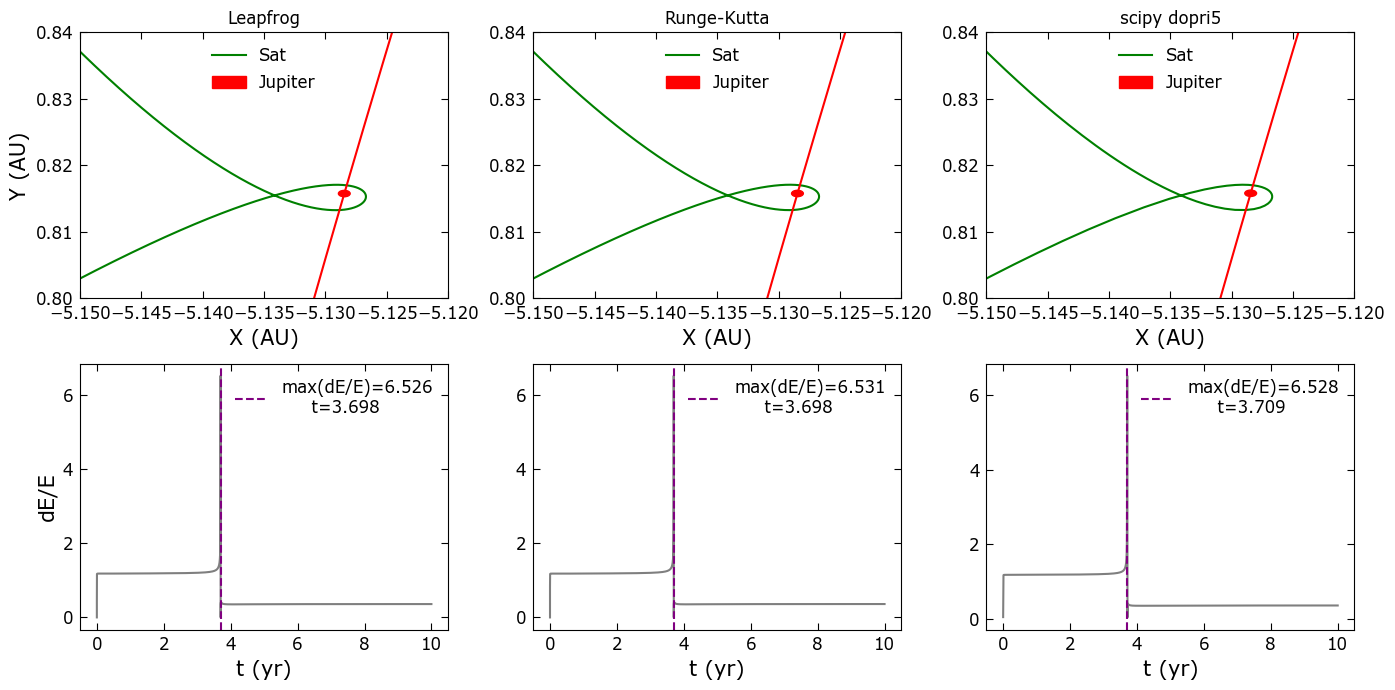

In [16]:
from matplotlib.patches import Circle

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
for i in [0, 1, 2]:
    # upper row: zoomed in paths
    ax = axes[0, i]
    ax.set_title(f'{names[i]}')
    ax.plot(rxs[i], rys[i], 'g-', label='Sat')
    ax.plot(rxe[i], rye[i], 'b--')
    ax.plot(rxj[i], ryj[i], 'r-')
    if i!=2:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    else:
        ax.add_patch(Circle((rxj[i][close_pts[i]], ryj[i][close_pts[i]]), radius=rJup_pl, color='red',label='Jupiter'))
    
    
    #ax.set_ylim(0.75, 0.85)
    ax.set_xlabel('X (AU)')
    ax.legend()
    if i == 0:
        ax.set_ylabel('Y (AU)')
        #ax.set_ylim(0.7, 0.74)
        #ax.set_xlim(-5.165, -5.135)
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
    else:
        ax.set_ylim(0.8,0.84)
        ax.set_xlim(-5.15, -5.12)
        
    # lower row: energy change
    ax = axes[1,i]
    ax.plot(rt[i], re[i], 'k', alpha=0.5)
    ax.axvline(rt[i][np.argmax(re[i])], color='purple',linestyle='--', label=f'max(dE/E)={np.max(re[i]):.3f}\n     t={rt[i][np.argmax(re[i])]:.3f}')
    ax.set_xlabel('t (yr)')
    #ax.set_xlim(3,4.2)
    if i==0:
        ax.set_ylabel('dE/E')
    ax.legend()
        
plt.tight_layout()
plt.show();


* As mentioned previously, increasing the mass of Mars by a factor of 1000, without any adjustments to the initial conditions, reproduces a similar orbit (w/ gravity assist) to what we saw before including the extra planet.

## Analysis
* Which numerical methods worked or did not work in this project
    * The methods used for ODE integration were Leapfrog, Runge-Kutta, and SciPy's dopri5 (an an explicit implementation of Runge-Kutta with order 5)
    * Each of the leapfrog methods were the most computationally exhausting, requiring the smallest combinations of timestep parameters of the 3 methods to converge. In my experience, even being off by ~$10^{-7}$ in initial timestep or timestep adjustment (hfactor) caused it to not converge to the proper orbit. The leapfrogs also took the longest at typically ~45 seconds.
    * The Runge-Kutta methods were the easiest to handle out of the 3, and didn't require as small of timestep parameters as the leapfrogs did to converge. They were also much faster being typically ~7 seconds.
    * The SciPy Runge-Kutta "dopri5" required some slight, but expected, maintenance with setting up the integrator with the best hyperparameters, but produced the best results once they were achieved. This is no different than adjusting the timestep parameters of our routines, just an extra layer due to it being through SciPy. It had the largest required timestep for convergence at $10^{-4}$ (compared to $10^{-8}$), and was consistently much faster with a typical execution time of ~2 seconds.
    * Once each method was properly setup, they reliably produced converged orbits that were fit for analysis.
* Lessons learned
    * Adjusting the implementations to include Mars allowed me to understand them more deeply.
    * I re-experienced the importance of reaching convergence with numerical approximations. Some of my orbits seemed completely off from what I expected until I finally used the best (and most computationally efficient) timestep parameters. It reminded me that these are discrete, numerical approximations, not analytic solutions, though the two are comparable at some limit depending on the problem.
* Further code improvements you could make with significantly more effort
    * I adjusted the intial conditions of Mars to start on the opposite side of Earth as the satellite, and this allowed me to reproduce the gravity assist when it was 1000x more massive, but not originally. I would've like to continue adjusting these, alongside the conditions of the other bodies, to see how the orbits would be skewed.]
    * I didn't get to explore the difference in results when the liftoff phase is changed.
    * I would've liked to try to force interesting orbits, such as double interactions, etc.
